AM 207 Final Project
# Forecasting "High" and "Low" of Financial Time Series by Particle Systems and Kalman Filters
*Team Member: Chih-Kang Chang, Jose Antonio Alatorre Sanchez, Yuying Qian*

In [1]:
from model import DataHandlerPriceForcastingModel
from model import ModelBackTest
from datetime import datetime, timedelta
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers.core import Dense
from rbf_keras.rbflayer import RBFLayer
from rbf_keras.kmeans_initializer import InitCentersKMeans

from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## Problem Statement

The goal of the paper is to predict the financial trend, e.g. stock price, using dynamic state space model. In the paper, the author uses the price of IBM from January 3, 1995 to May 26, 1999. In the following implementation, we use SPY price instead. Compared to the stock price of a single company, we believe SPY, an ETF tracking the S&P 500 stock market index, may be less susceptible to specific financial events that are not included in the model. In addition, we use a much shorter data, from Aug 12 to Oct 24, 2019, due to the time and complexity constraints for the project.

We split the data into 3 portion, training (60%), validating (20%), and testing (20%). The validation dataset is not used in training but is used for hyper-parameters selection, and the testing dataset is not used in any way and it is for evaulation only. 

In [2]:
data = DataHandlerPriceForcastingModel('SPY_1M.csv',timedelta(hours=3),timedelta(minutes=60),0.6)

_, price_train, _, _ = data.get_sample_split_by_day_train()
_, price_validate, _, _ = data.get_sample_split_by_day_validate()
_, price_test, _, _ = data.get_sample_split_by_day_test()

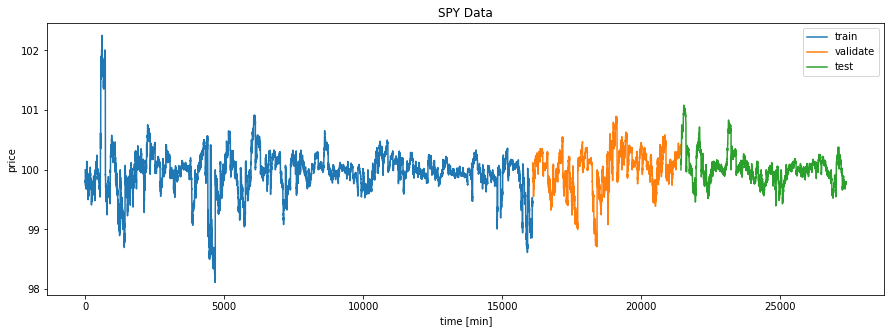

In [3]:
def plotContinueData(ys):
    x = [-1]
    for y in ys:
        x = np.arange(x[-1]+1, x[-1]+1 + y.shape[0])
        plt.plot(x, y)

figsize=(15,5)
plt.figure(figsize=figsize)
plotContinueData([np.concatenate(price_train),np.concatenate(price_validate),np.concatenate(price_test)])
plt.xlabel('time [min]')
plt.ylabel('price')
plt.legend(['train','validate','test'])
plt.title('SPY Data')

plt.show()

In order to avoid high linearity and reduce dimension, the author smoothes the rough data by projecting them onto a functional basis, i.e. polynomial curves, and uses the coefficients of this projection for modelling purposes. The author projects the data with an interval of 3 hours to a spline function of 5 nodes.

In [4]:
def projectSpline(spline_node, ys):
    S_basis = []
    coeff = []
    poly = PolynomialFeatures(degree=spline_node-1)
    for y in ys:
        s = poly.fit_transform(np.arange(y.shape[0]).reshape((-1,1)))
        s /= s.max(axis=0)
        S_basis.append(s)
        coeff.append(np.linalg.pinv(s).dot(y))
        
    return S_basis, np.array(coeff)
    
spline_node = 5
S_train, coeff_train = projectSpline(spline_node, price_train)
S_validate, coeff_validate = projectSpline(spline_node, price_validate)
S_test, coeff_test = projectSpline(spline_node, price_test)
price_total = price_train+price_validate+price_test
S_total, coeff_total = projectSpline(spline_node, price_total)

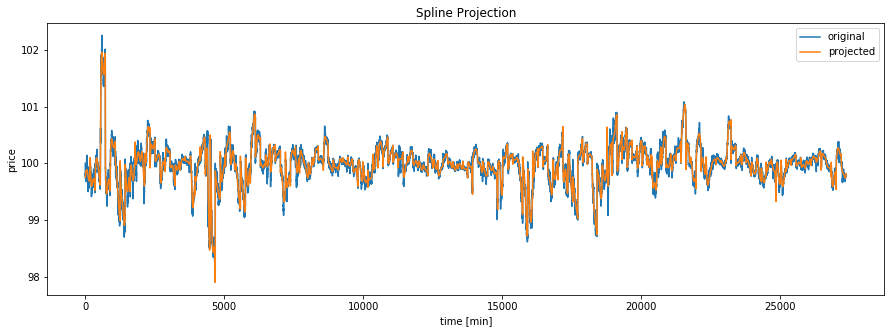

In [5]:
plt.figure(figsize=figsize)
plotContinueData([np.concatenate([np.concatenate(price_train),np.concatenate(price_validate),np.concatenate(price_test)])])
plotContinueData([np.concatenate([np.concatenate([S_train[i].dot(coeff_train[i]) for i in range(len(coeff_train))]),
                                   np.concatenate([S_validate[i].dot(coeff_validate[i]) for i in range(len(coeff_validate))]),
                                   np.concatenate([S_test[i].dot(coeff_test[i]) for i in range(len(coeff_test))])])])
plt.xlabel('time [min]')
plt.ylabel('price')
plt.legend(['original','projected'])
plt.title('Spline Projection')

plt.show()

In [6]:
print('The original data length is {}'.format(np.concatenate([np.concatenate(price_train),np.concatenate(price_validate),np.concatenate(price_test)]).shape[0]))
print('The projected data length is {}'.format(len(coeff_train) + len(coeff_validate) + len(coeff_test)))

The original data length is 27373
The projected data length is 153


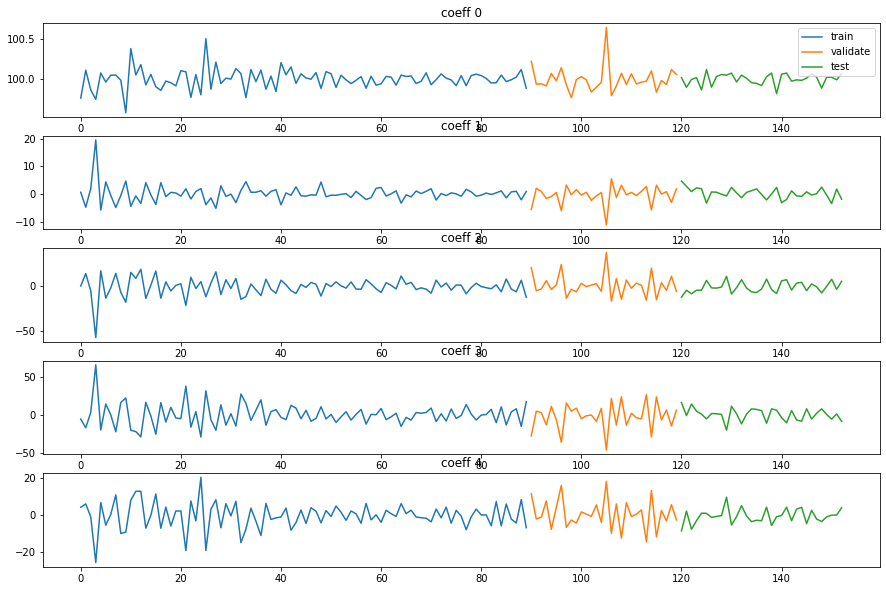

In [7]:
fig, axes = plt.subplots(spline_node,1,figsize=(figsize[0],10))
for i in range(spline_node):
    plt.sca(axes[i])
    plotContinueData([np.array([coeff[i] for coeff in coeff_train]),
                       np.array([coeff[i] for coeff in coeff_validate]),
                       np.array([coeff[i] for coeff in coeff_test])])
    axes[i].set_title('coeff '+str(i))
axes[0].legend(['train','validate','test'])

plt.show()

We now successfully project the original 1D data of 27373 data point, where adjacent data points are highly correlated, to a new 5D data of 153 data point, where adjacent data points are not highly correlated. In the following report, we use this projection method with different time intervals and apply different estimation models.

## Methods

The author propeses a trading strategy based on two models. 

First, the author constructs a "Price Forecasting Model". The objective of the model is projecting the data to two spaces, the IN space and the OUT space, with clustering via the EM algorithm. The IN space containing the functional basis projection of prices in the time range [t, t+t_in] and the OUT space with projection of the prices in the time range [t, t+t_in+t_out]. Once both spaces are projected, the author utilizes Radial Basis Function Networks (RBFN) to estimate the transition dynamics between the IN pace and the out Space.

The second model, "Trading Model", also tries to explain the transition between the projected coefficients, while this model utilizes the dynamic state space model to estimate the projected coefficients using filtering techiniques.

Once the two models are fit, the author makes a trading decision if both models indicate a trend. We do not involve the trading component in the report as this is out of the scope of the class.

### The Price Forecasting Model

The full code is imported from an attached py file. The notebook is only used for showing the implementaiton. 

The class ModelBackTest fits several models and back test which of them has the greater number of correct trend predictions. i.e. Correct number of up or down trend.

#### Observations

While it is an interesting concept to project sparse intraday data to a clustered functional representation we find the following problems with this model:

1. Even when we select a higher number of clusters, the EM algorithm ends up selecting a few number of them. Even more it tends to select clusters with many curves averaging all the shapes in to a flat curve.

2. Even that the RBF seems to fit correctly, when we try to perform forecast the predictions is extremely poor. The reason for this seems to be that we don't have enough data when we go from one cluster to the other in the IN-OUT Space. For example in the first fit below the prediction of the training curves is extremely bad. However in the second fit, when we reduce the number of clusters to only 1 the prediction improves.

Fitting model: 0 out of 2


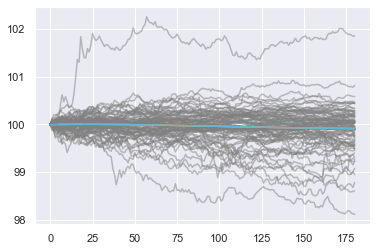

Error after iteration 0 2223.058834028764


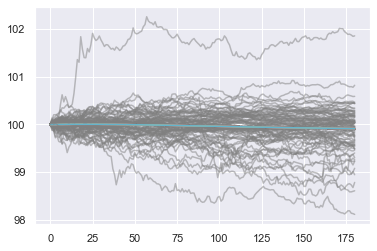

Error after iteration 1 2223.042947815089
Error after iteration 2 2223.0429478147216
Error after iteration 3 2223.0429478147216
Error after iteration 4 2223.0429478147216


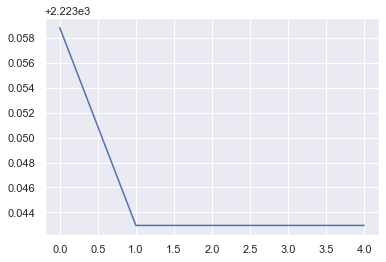

Fitting model: 1 out of 2


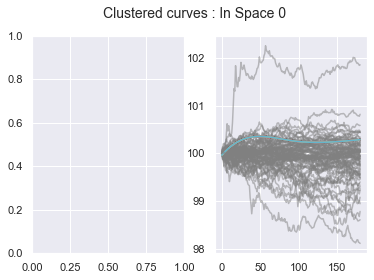

Error after iteration 0 2961.8037609069825


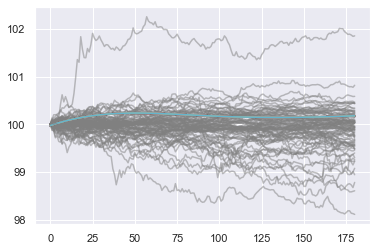

Error after iteration 1 2224.347878066934
Error after iteration 2 2224.5105748649744
Error after iteration 3 2223.8731119807817
Error after iteration 4 2223.442265029145


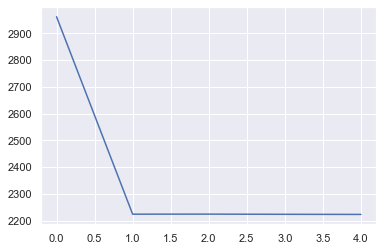

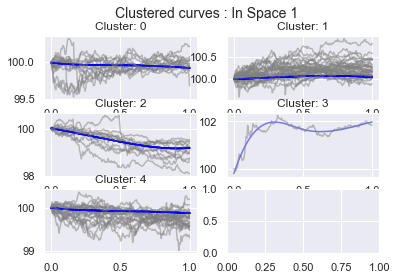

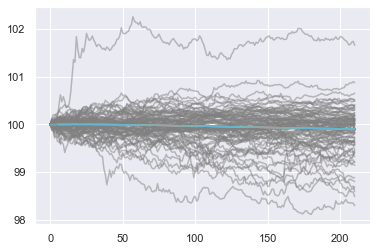

Error after iteration 0 2848.5053628707246


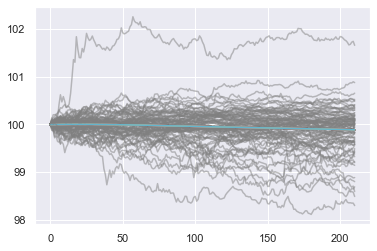

Error after iteration 1 2848.6049220860505
Error after iteration 2 2848.5522404299645
Error after iteration 3 2848.522075599708
Error after iteration 4 2848.510705419041
Error after iteration 5 2848.5067003609693
Error after iteration 6 2848.505327412313
Error after iteration 7 2848.50486499594
Error after iteration 8 2848.504711095781
Error after iteration 9 2848.504660103261


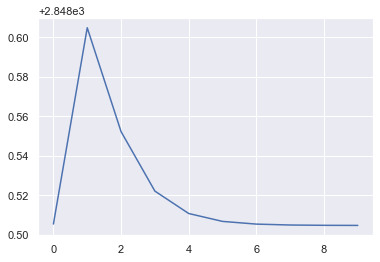

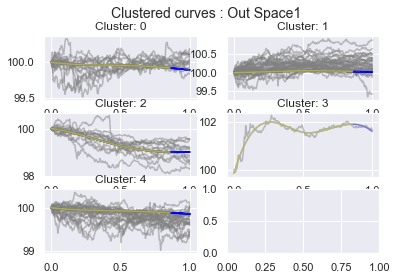

Training model cluster_rbf_0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


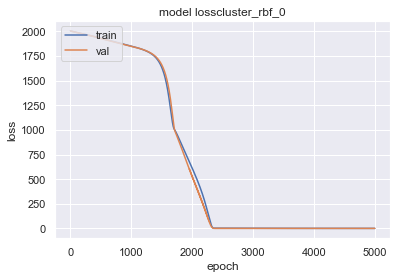

Training model cluster_rbf_1


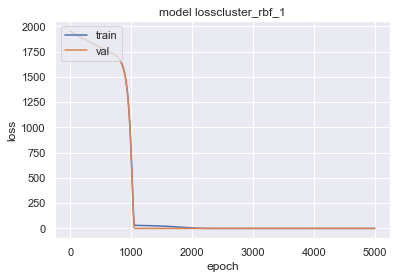

Training model cluster_rbf_2


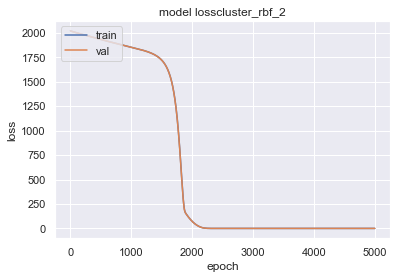

Training model cluster_rbf_3
Training model cluster_rbf_4


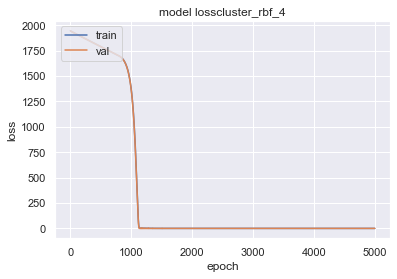

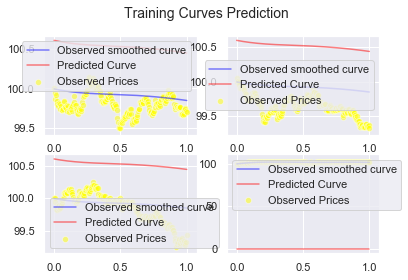

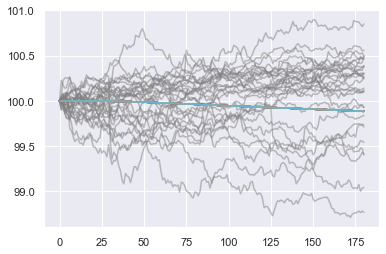

Error after iteration 0 629.4928437276055


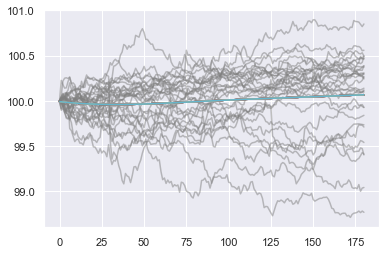

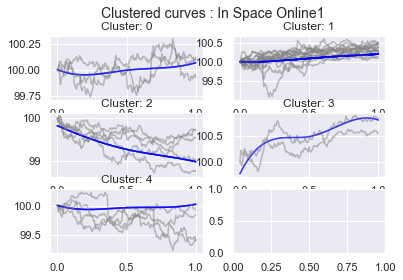

In [8]:
t_in_list=[timedelta(hours = 3)]
t_out_list=[timedelta(minutes = 30)]
q_spline_knots=[5]
G_clusters=[1,5]
rbf_hidden=[3]
back_test=ModelBackTest(t_in_list=t_in_list,t_out_list=t_out_list,
                        q_spline_knots=q_spline_knots,G_clusters=G_clusters,
                        rbf_hidden=rbf_hidden)
sns.set()
back_test.validate()

### The Price Forecasting Model

In this model, instead of estimating the transition from IN space to OUT space, we treated the projected coefficients as the state of a dynamic state space model, and implement the Unscented Kalman Filter and Particle Filter to estimate it. 

#### Nomalization
As we will use a RBFN as the transition function of the dynamic state space model, we would like the state to be normalized so that the training result of the network can be more stable and the weight for each dimension can be equal. We use MinMaxScaler to normalize the coefficients.

In [9]:
coeff_scaler = MinMaxScaler()
coeff_scaler.fit(coeff_train)

coeff_train_norm = coeff_scaler.transform(coeff_train)
coeff_validate_norm = coeff_scaler.transform(coeff_validate)
coeff_test_norm = coeff_scaler.transform(coeff_test)
coeff_total_norm = coeff_scaler.transform(coeff_total)

#### Radial Basis Funcion Network
The author uses a Dynamic State Space Model to predict the change of the coefficients over time, where
$$\begin{align}
x_{k+1} &= f(x_k) + v_k \\
y_k &= h(x_k) + n_k
\end{align}$$,
- $x_k$ is the state, in this case, the coefficient for the $k$-th interval
- $v_k$ is the processing noise
- $y_k$ is the observation, in this case, the coefficient for the $k$-th interval
- $n_k$ is the measurment noise

Nevertheless, this transition function $f$ and observation function $h$ of the Dynamic State Space Model is unknown and non-linear. The author then uses Radial Basis Function Networks (RBFNs) to approximate these functions. In our implementation, we appoximate the transition function as the RBFN trained with `coeff[:-1]` as the input and `coeff[1:]` as the output, so that the function can predict the coefficient (state) in the next time step. Furthermore, we did not train a observation function and implement it simply as an identity function. 

RBFN is a single-layer neural network of which the activation function is a radial basis function, i.e.
$$\phi_i = e^{-\frac{(x_k - c_i)^T(x_k - c_i)}{\sigma_i}}$$,
- $\phi_i$ is the activation output for $i$-th node
- $c_i$ is the center of $i$-th node
- $\sigma_i$ is the scale of $i$-th node

The output of the RFBN is then the linear combination of each node, i.e.
$$f(x_k) = \sum_{i=1}^I  \lambda_i e^{-\frac{(x_k - c_i)^T(x_k - c_i)}{\sigma_i}}$$

$\lambda$, $c$, and $\sigma$ are the parameters we'd like to train for the network. The author refer to the literature [*Benoudjit and Verleysen, 2003*](https://link.springer.com/article/10.1023/A:1026289910256) to train the network. In that paper,
- the center $c$ is calculcated using the k-mean clustering algorithm
- the scale $\sigma$ is calculated based on the equation $\sigma_i = \frac{1}{p} \left(\sum_{j=1}^p ||c_i - c_j||^2\right)^{\frac{1}{2}}$, where $c_j$ are the $p$-nearest neighbours to centroid $c_i$, and $p$ is suggested as 2. 
- The weight $\lambda$ is calculated using pseudo-inverse, $\lambda = \phi^{+} y$

We utilize the RBF layer introduced in [*RBF-Keras: an RBF Layer for Keras Library, 2019*](https://github.com/PetraVidnerova/rbf_keras) and implement the network in keras. In the library, all the centers, scales, and the weights are trained.

In the paper, the author tried the node number of 2, 4, and 6, while no detail comparism was given. We perform a cross validation to decide what node number is more preferable.

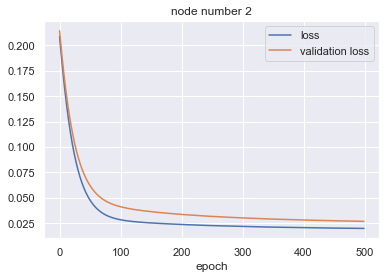

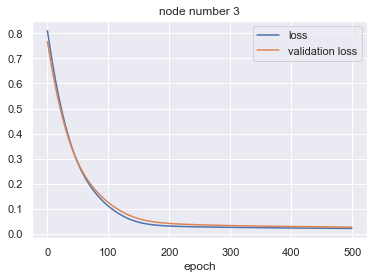

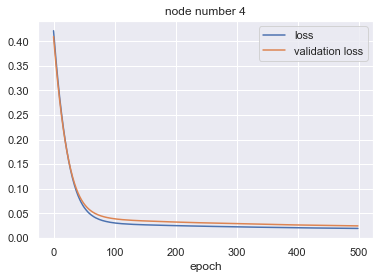

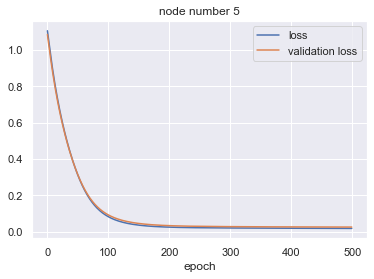

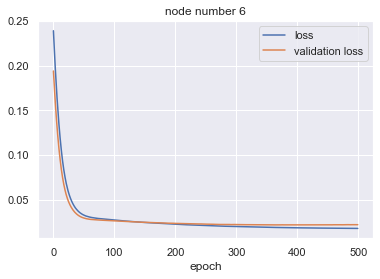

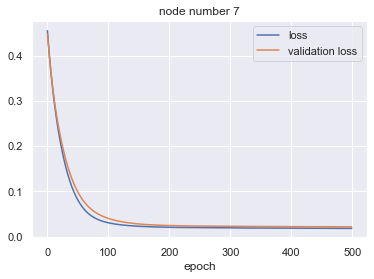

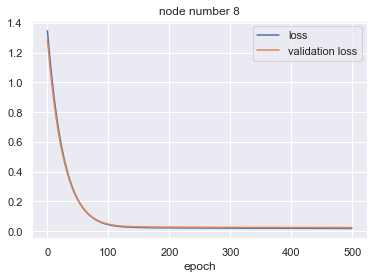

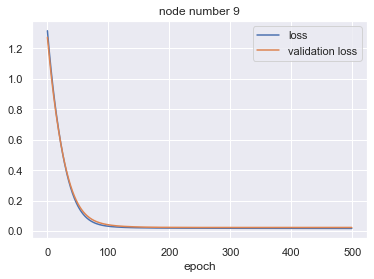

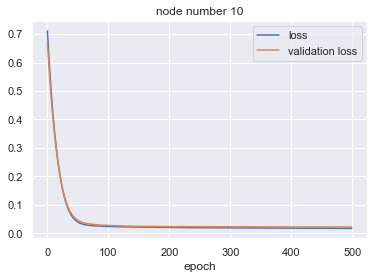

In [10]:
node_list = np.arange(2,11)
loss = []
val_loss = []

for n in node_list:
    model = Sequential()
    model.add(RBFLayer(n,
                       initializer=InitCentersKMeans(coeff_train_norm),
                       input_shape=(spline_node,)))
    model.add(Dense(spline_node))
    model.compile(loss='mse',optimizer='adam')
    history = model.fit(coeff_train_norm[:-1],coeff_train_norm[1:],
                        validation_data=(coeff_validate_norm[:-1],coeff_validate_norm[1:]),
                        epochs=500,verbose=False)
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['loss','validation loss'])
    plt.xlabel('epoch')
    plt.title('node number '+str(n))
    
    loss.append(history.history['loss'][-1])
    val_loss.append(history.history['val_loss'][-1])
    
    

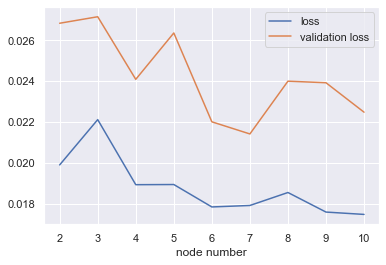

In [11]:
plt.plot(node_list,loss)
plt.plot(node_list,val_loss)
plt.legend(['loss','validation loss'])
plt.xlabel('node number')

plt.show()

From the cross validation, we choose `node_n = 4`.

In [12]:
node_n = 4
transition = Sequential()
transition.add(RBFLayer(node_n,
                        initializer=InitCentersKMeans(coeff_train_norm),
                        input_shape=(spline_node,)))
transition.add(Dense(spline_node))
transition.compile(loss='mse',optimizer='adam')
history = transition.fit(coeff_train_norm[:-1],coeff_train_norm[1:],
                         validation_data=(coeff_validate_norm[:-1],coeff_validate_norm[1:]),
                         epochs=500,verbose=False)

In [13]:
def plotCoeffPerformace(X_true, X_pred):
    dim = X_true.shape[1]
    fig, axes = plt.subplots(dim,1,figsize=(figsize[0],10))
    for i in range(X_true.shape[1]):
        axes[i].plot(X_true[:,i], label='true')
        axes[i].plot(X_pred[:,i], label='pred')
        axes[i].set_title('coeff '+str(i))
    axes[0].legend()
    return axes

In [14]:
def vline_label(x1, x2, ax=None):
    if ax is None:
        ax = plt
        y_min = plt.ylim()[0]
    else:
        y_min = ax.get_ylim()[0]
    ax.axvline(x1,color='k')
    ax.annotate('validate',(x1+1,y_min))
    ax.axvline(x1+x2,color='k')
    ax.annotate('test',(x1+x2+1,y_min))

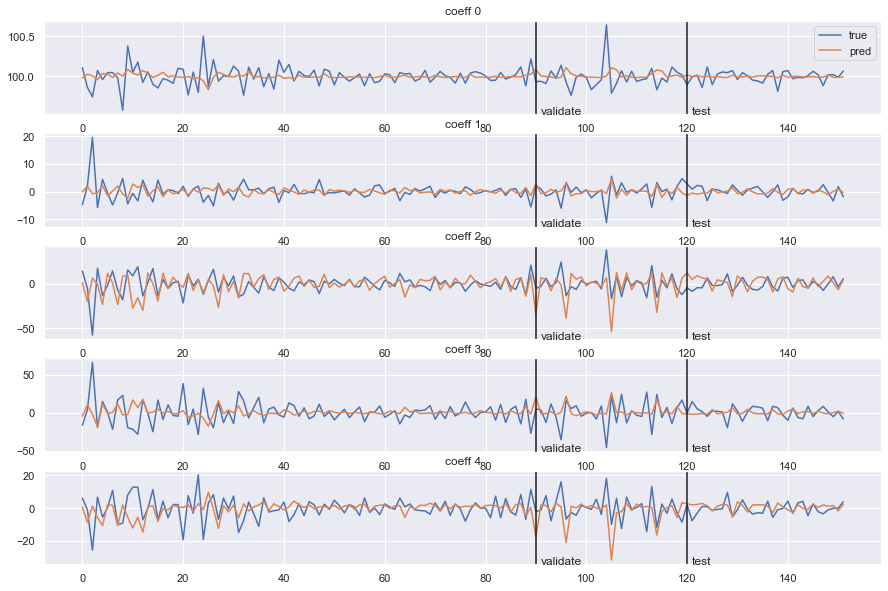

In [15]:
axes = plotCoeffPerformace(coeff_total[1:], coeff_scaler.inverse_transform(transition.predict(coeff_total_norm[:-1])))
for ax in axes:
    vline_label(len(coeff_train), len(coeff_validate), ax)

In [16]:
def plotPricePerformace(Y_true, X_pred, S):
    Y_full_true = np.concatenate(Y_true)
    Y_full_pred = []
    for i, X in enumerate(X_pred):
        Y_full_pred.append(S[i].dot(X))
    Y_full_pred = np.concatenate(Y_full_pred)
    
    plt.plot(Y_full_true)
    plt.plot(Y_full_pred)

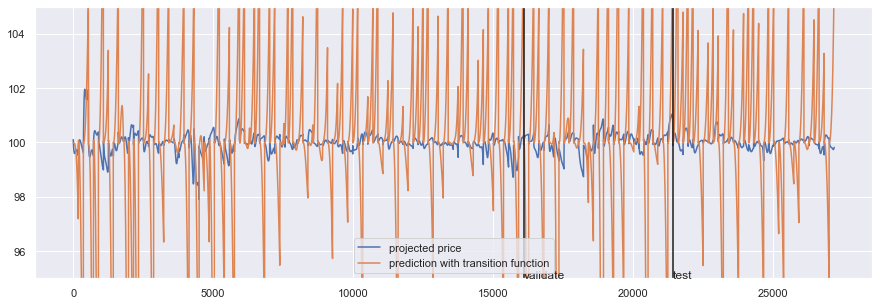

In [17]:
plt.figure(figsize=figsize)
plotPricePerformace([S_total[i].dot(X) for i, X in enumerate(coeff_total[1:])], coeff_scaler.inverse_transform(transition.predict(coeff_total_norm[:-1])), S_total[1:])
plt.legend(['projected price','prediction with transition function'])
plt.ylim([95,105])
vline_label(len(np.concatenate(price_train)), len(np.concatenate(price_validate)))

plt.show()

We can see that the performance of the transition function is not very good, and of course the predicted price is not accurate. This may be improved by using a different neural network, for example, multiple layer RFBN, RNN, and so on. However, as this is the author's proposal, we will use the trained RFBN as the transition function.

#### Filtering

Once we have the dynamic state space model with the approximated transition function, we can apply filtering technique to estimate the state. The aurthor proposed two techniques, Unscented Kalman Filter and Particle Filter. We implement the UKF with the built-in function in the library `filterpy` referring to the [Kalman-and-Bayesian-Filters-in-Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/) document.

***Unscented Kalman Filter***

In the UKF, we use a common sigma piont generator proposed by Rudolph Van der Merwe, which has been shown to perform well with a variety of problems and it has a good tradeoff between performance and accuracy. This generator uses 3 parameters to control how the sigma points are distributed and weighted: $\alpha$, $\beta$, and $\kappa$.
- $\beta=2$ is a good choice for Gaussian problems
- $\kappa=3-n$ where $n$ is the dimension of the state is a good choice for $\kappa$
- $0 \le \alpha \le 1$ is an appropriate choice for $\alpha$, where a larger value for $\alpha$ spreads the sigma points further from the mean.
- This will give us $2n+1$ sigma points

We initial the UKF with following settings,
- initial state $x_0$: choose the center of the range (0.5)
- initial covariance $P_0$: as the initial is unsure, choose a big number (3 compared to the range [0,1])
- covariance of processing noise $Q$: as we can see above, the transition function is not very accurate. Choose $Q$ as four times of the variance of predicted result.
- covariance of measurement noise $R$: as the observation is the identity function, the noise should be small. Choose $R$ as quater of the processing noise.

In [18]:
points = MerweScaledSigmaPoints(n=spline_node, alpha=0.1, beta=2, kappa=3-spline_node)

ukf = UnscentedKalmanFilter(
    dim_x=spline_node, 
    dim_z=spline_node, 
    fx=lambda x, dt: transition.predict(np.expand_dims(x, axis=0)), 
    hx=lambda x:x,
    points=points,
    dt=1)

ukf.x = 0.5*np.ones((spline_node,))
ukf.P = 3*np.eye(spline_node)
ukf.Q = 4*np.diag(((transition.predict(coeff_train_norm[:-1])-coeff_train_norm[1:])**2).sum(axis=0)/(len(coeff_train_norm)-2)) 
ukf.R = np.diag(coeff_train_norm.var(axis=0))/4 #

ukf.Wm /= ukf.Wm.sum()
ukf.Wc /= ukf.Wc.sum()

## Results


### Unscented Kalman Filter

In [19]:
xs, ps = ukf.batch_filter(coeff_total_norm[1:])

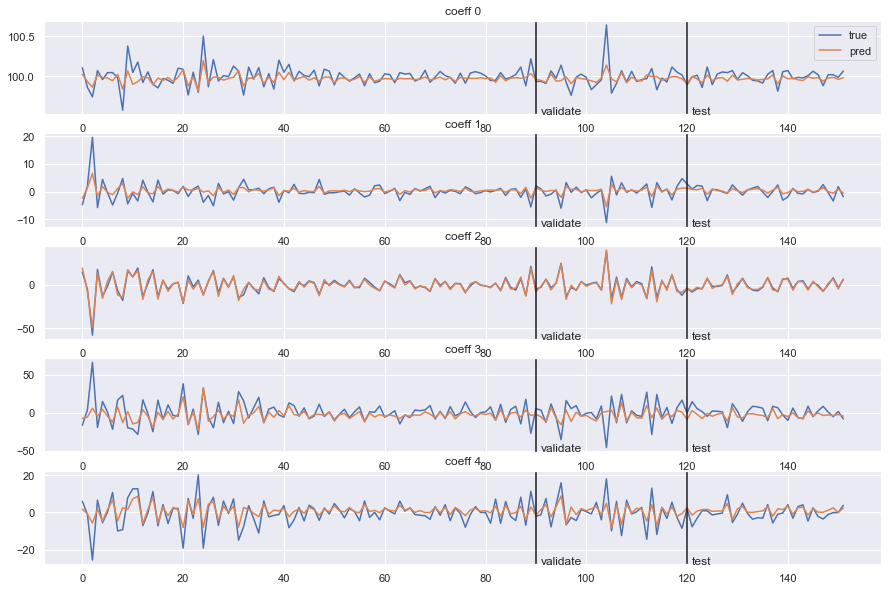

In [20]:
axes = plotCoeffPerformace(coeff_total[1:], coeff_scaler.inverse_transform(xs))
for ax in axes:
    vline_label(len(coeff_train), len(coeff_validate), ax)
    
plt.show()

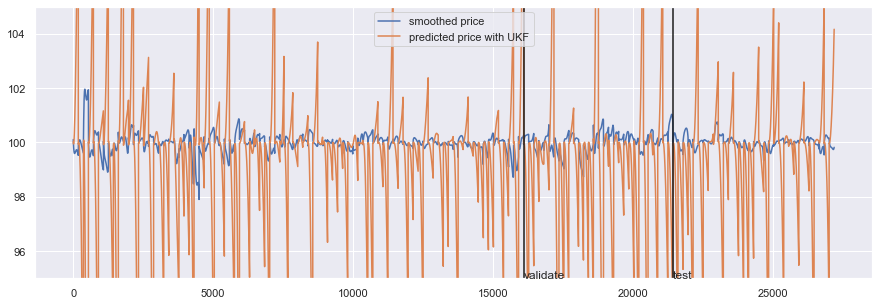

In [21]:
plt.figure(figsize=figsize)
plotPricePerformace([S_total[i].dot(X) for i, X in enumerate(coeff_total[1:])], coeff_scaler.inverse_transform(xs), S_total[1:])
plt.legend(['smoothed price','predicted price with UKF'])
plt.ylim([95,105])
vline_label(len(np.concatenate(price_train)), len(np.concatenate(price_validate)))

plt.show()

## Discussion

From the prediction, we can see that the trend of the prediction is closer to the actual price than simply applying transition function. However, the prediction is still inaccurate. When we play around with the covariace of the processing noise and the measurement noise, we soon realize that the correction mainly comes from the observation, and the transition has much less to do with the prediction. This is unddrstandable as the transition function is not well approximated with the RFBN. For this reason, we do not implement the Particle Filter, as the main objective of using Particle Filter is to avoid Gaussian noise assumption in the UKF, and we assume it would not work any better if the Dynamic State Space Model is inaccurate.

In addition, one observation we have from the predi ction result is that the slope of the projected curve is much higher than the origibal curve. As the nature of the functional basis projection, each coefficient has different contribution to the price: for the coefficient of lower oder, it's more effective for offset and slower change, and for the coefficient of higher order, it's more effective for time trend and high frequency change. Thus, if we weigh each coefficient differently while training the transition RBFN and updating the state of Kalman filter, we may have a high chance to get better results.